<a href="https://colab.research.google.com/github/JugglingNumbers/intraday_nope_research/blob/data_clean/NOPE_results_reproduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### created by @JugglingNumbers JugglingNumbers1@gmail.com

### **Load the data**

In [2]:
import pandas as pd
import numpy as np

In [3]:
!git clone https://github.com/The-NOPE-Project/intraday_nope_research
%cd intraday_nope_research/scripts
DATA_PATH = "/content/intraday_nope_research/processed_data/"
all_data = pd.read_csv(DATA_PATH + 'allDataCombined.csv').loc[:,['timestamp', 'C', 'P', 'netDelta', 'stockVolumeAll', 'stockVolumeBus',
                                                                  'numStockTransactions', 'NOPE_busVolume', 'NOPE_allVolume', 'spyPrice']]

Cloning into 'intraday_nope_research'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 142 (delta 58), reused 109 (delta 30), pack-reused 0
Receiving objects: 100% (142/142), 6.10 MiB | 17.86 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/intraday_nope_research/scripts


In [4]:
df = all_data.copy()
df['timestamp'] = pd.Index(pd.to_datetime(df['timestamp'])).tz_localize('US/Eastern')
df['ret'] = df['spyPrice'].pct_change().values
df['ret2'] = df['ret'].pct_change().values
df['ret3'] = df['ret2'].pct_change().values
df['nope'] = df['NOPE_busVolume'].pct_change().values
df['nope2'] = df['nope'].pct_change().values
df['nope3'] = df['nope2'].pct_change().values

strat = df.copy().set_index('timestamp')
strat.index = pd.to_datetime(strat.index)
strat['time'] = strat.index.strftime("%H:%M:%S")

### **Functions**

In [5]:
from functools import partial

def mrMask(df, nope_col, strat_col, entry, exit, stop, no_overnight_trades, alt_time_rules):
  if not alt_time_rules:
    time_rules = (df['time'] < "16:00:00") & (df['time'] > "09:30:00")
  else:
    time_rules = alt_time_rules
  adj = 1

  if (stop < entry) & (entry < exit):
    STRAT = 'LONG'
  elif (stop > entry) & (entry > exit):
    STRAT = 'SHORT'
    adj = -1
  else:
    raise AssertionError("stop > entry > exit or stop < entry < exit is required for mean reversion strategies")

  ret_mask = True #(df['ret2']<0)
  entry_mask = (adj*df[nope_col] <= adj*entry) & ret_mask & time_rules #& (adj*df[nope_col].shift(1)>adj*entry) 
  start_mask = (adj*df[nope_col] <= adj*entry) & (df['time'] == "09:30:00") & ret_mask #& (adj*df[nope_col].shift(1)>adj*entry)
  exit_mask = ((adj*df[nope_col] >= adj*exit) & ret_mask) | (adj*df[nope_col] <= adj*stop)

  df[strat_col] = np.where(entry_mask | start_mask, 1, np.nan)
  df[strat_col] = np.where(exit_mask,-1, df[strat_col])
  
  if no_overnight_trades:
    df[strat_col] = np.where(df['time'] >= "16:00:00", -1, df[strat_col])

  return df

def calcStrat(df, 
              index_name = 'timestamp', 
              nope_col = 'NOPE_busVolume', 
              price_col = 'spyPrice', 
              strat_col = 'strat', 
              entry = -50, 
              exit = -30, 
              stop = -100, 
              no_overnight_trades = True, 
              alt_time_rules = False, 
              mask_func = mrMask
              ):
  
  assert str(type(df)) == "<class 'pandas.core.frame.DataFrame'>"
  assert ((df.index.name == index_name) & (np.all([True for col in [nope_col,price_col,'time'] if col in df.columns])))
  if np.abs(df[nope_col].mean())<1:
    df[nope_col] *= 100

  fn = partial(mask_func, df, nope_col, strat_col, entry, exit, stop, no_overnight_trades)
  df = fn(alt_time_rules)
  df = calc_allocations_and_trades(df, index_name, nope_col, price_col, strat_col)

  if (stop > entry) & (entry > exit): #STRAT == 'SHORT':
    df['allocations'] *= -1
    df['pct_profit'] *= -1

  return df

def calc_allocations_and_trades(df, index_name, nope_col, price_col, strat_col = 'strat'):
  assert (str(type(df)) == "<class 'pandas.core.frame.DataFrame'>" )
  assert ((df.index.name == index_name) & (np.all([True for col in [nope_col,price_col,strat_col] if col in df.columns])))
  allocations = np.full((len(df),1),np.nan)
  trade_in_progress = False
  trade_start_index = None

  new_columns=['entry_price','entry_nope','entry_time','exit_price','exit_nope','exit_time']
  new_col_arr = np.full((len(df),6),np.nan)
  index = df.index.copy()
  df = df.reset_index()
  df[index_name] = df[index_name].astype(int)

  colLoc = dict(zip(df.columns,np.arange(1,len(df.columns)+1)))

  for i, row in enumerate(df.itertuples()):
    if (row[colLoc[strat_col]] == 1) & (not trade_in_progress):
      allocations[i] = 1
      new_col_arr[i, :3] = [row[colLoc[price_col]], row[colLoc[nope_col]], row[1]]
      trade_in_progress = True
      trade_start_index = i
    elif (row[colLoc[strat_col]] == -1) & trade_in_progress:
      trade_in_progress = False
      new_col_arr[trade_start_index,-3:] = [row[colLoc[price_col]], row[colLoc[nope_col]], row[1]]
    elif trade_in_progress:
      allocations[i] = 1

  df.loc[:,new_columns] = new_col_arr
  df = df.set_index(index_name)
  df.index = pd.to_datetime(df.index).tz_localize('UTC').tz_convert('US/Eastern')
  df['entry_time'] = pd.DatetimeIndex(pd.to_datetime(df['entry_time'], utc=True)).tz_convert('US/Eastern')
  df['exit_time'] = pd.DatetimeIndex(pd.to_datetime(df['exit_time'], utc=True)).tz_convert('US/Eastern')

  df['allocations'] = allocations

  df['ret'] = df[price_col].pct_change()
  df['pct_profit'] = (df['exit_price'] / df['entry_price'] -1)
  df['dow'] = df.index.dayofweek
  df['hour'] = df.index.hour

  return df

In [6]:
def mrMask_ShortHours(df, nope_col, strat_col, entry, exit, stop, no_overnight_trades, alt_time_rules):
  if not alt_time_rules:
    time_rules = (df['time'] <= "15:15:00") & (df['time'] > "09:49:00")
  else:
    time_rules = alt_time_rules
  adj = 1

  if (stop < entry) & (entry < exit):
    STRAT = 'LONG'
  elif (stop > entry) & (entry > exit):
    STRAT = 'SHORT'
    adj = -1
  else:
    raise AssertionError("stop > entry > exit or stop < entry < exit is required for mean reversion strategies")

  ret_mask = True #(df['ret2']<0)
  entry_mask = (adj*df[nope_col] <= adj*entry) & ret_mask & time_rules & (adj*df[nope_col].shift(1)>adj*entry) 
  start_mask = (adj*df[nope_col] <= adj*entry) & (df['time'] == "09:50:00") & ret_mask
  exit_mask = ((adj*df[nope_col] >= adj*exit) & ret_mask) | (adj*df[nope_col] <= adj*stop)

  df[strat_col] = np.where(entry_mask | start_mask, 1, np.nan)
  df[strat_col] = np.where(exit_mask,-1, df[strat_col])
  
  if no_overnight_trades:
    df[strat_col] = np.where(df['time'] >= "15:30:00", -1, df[strat_col])

  return df


In [7]:
from tqdm import tqdm
import itertools as it

def calcTradeResults(df):
  ### Reproducing Isaac's columns ###
  df['total_trades'] = df['entry_price'].notnull().sum()
  df['success_rate'] = np.where((df['pct_profit'] > 0),True,False).sum() / df['total_trades'].values[0]
  df['total_PNL'] = ((df['exit_price'] -df['entry_price'])*df['allocations'])
  df['mean_of_returns'] = df['total_PNL'].mean()
  df['standard_deviation'] = df['total_PNL'].std()
  df['total_PNL'] = df['total_PNL'].sum()
  df['average_hold_time'] = (df['exit_time'] - df['entry_time']).mean().total_seconds()/60
  df['median_hold_time'] = (df['exit_time'] - df['entry_time']).median().total_seconds()/60

  return df

def calcAllStrats(df, combos, mask_func = mrMask):
  results = []
  ensembles = []
  variable_col_names = ['entry','exit','stop']
  for variables in tqdm(combos):
    entry, exit, stop = variables
    res = calcStrat(df, entry = entry, exit = exit, stop = stop, mask_func=mask_func)

    res = calcTradeResults(res)

    res['strat_name'] = "".join([str(i) for i in variables])
    res.loc[:,variable_col_names] = np.tile(variables, len(res)).reshape((len(res),len(variables)))
    results.append(res)
    
    res['allocations'] = res['allocations'].fillna(0)
    ensembles.append(res.loc[:,['allocations','strat_name']].shift(1))
  
  results = pd.concat(results,axis=0)
  trades = results.loc[results.entry_price.notnull()]
  trades = trades.sort_index()

  return results, ensembles, trades

def plotTradeReturns(trades, row_mask, trade_adjust=231, label='-50,-30,-100', figsize=(6,4)):
  if not trade_adjust:
    trade_adjust = len(trades.loc[row_mask,'strat_name'].unique())
  filtered = trades.loc[row_mask, 'pct_profit']
  ((filtered / trade_adjust)+ 1).cumprod().plot(label=label, figsize=figsize, legend=True)
  col_names = ['num_trades','mean_ret','ret_std','ret_skew', 'success_rate']
  values =np.asarray([filtered.shape[0], filtered.mean(), filtered.std(), filtered.skew(), trades.loc[row_mask & (trades.pct_profit > 0),'ret'].count() / filtered.shape[0]]).reshape((1,-1))
  return pd.DataFrame(values, columns=col_names, index=[label])

### **Stops at +- 100 reproducing results.csv in the repo**

In [8]:
combos = []
### list of [ENTRY, EXIT, STOP] combos to run
combos.extend([list(i) for i in it.product(*[np.arange(-95,-5,5),np.arange(-85,5,5),[-100]]) if ((i[0] < i[1]) & (i[2] < i[0]))])
combos.extend([list(i) for i in it.product(*[np.arange(95,5,-5),np.arange(85,-5,-5),[100]]) if ((i[0] > i[1]) & (i[2] > i[0]))])
combos = [combo for combo in combos if ~((np.abs(combo[0] - combo[1]) < 10))]

results, ensembles, trades = calcAllStrats(strat, combos, mask_func=mrMask)

100%|██████████| 342/342 [00:51<00:00,  6.64it/s]


In [9]:
print('Average trade percent profit',trades.pct_profit.mean())

Average trade percent profit 0.00016925130966782432


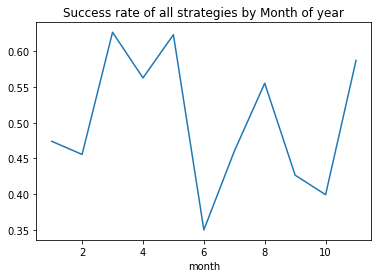

In [10]:
### stops are bad for success rates by month

trades['month'] = trades.index.month
trades.groupby(['month'])['pct_profit'].apply(lambda x: (x > 0).sum() / x.count()).plot(title="Success rate of all strategies by Month of year")

In [11]:
all_strats = trades.groupby('strat_name').first().loc[:,['entry',	'exit', 'stop',	'success_rate',	'total_trades', 'total_PNL',	'mean_of_returns',	'standard_deviation', 'average_hold_time',	'median_hold_time']]
longs = all_strats.loc[all_strats.entry < 0].sort_values(by=['entry','exit'], ascending=False)
shorts = all_strats.loc[all_strats.entry > 0].sort_values(by='entry', ascending=True)


In [12]:
### matches results.csv
longs

,entry,exit,stop,success_rate,total_trades,total_PNL,mean_of_returns,standard_deviation,average_hold_time,median_hold_time
strat_name,,,,,,,,,,
-100-100,-10,0,-100,0.615385,572,45.7596,0.079999,1.904100,70.882867,35.0
-150-100,-15,0,-100,0.585938,512,56.2506,0.109864,1.999094,75.673828,40.0
-15-5-100,-15,-5,-100,0.615799,557,43.8952,0.078806,1.856868,65.583483,35.0
-200-100,-20,0,-100,0.554348,460,23.7976,0.051734,1.978677,79.065217,40.0
-20-5-100,-20,-5,-100,0.584178,493,22.7012,0.046047,1.835001,69.837728,35.0
...,...,...,...,...,...,...,...,...,...,...
-95-65-100,-95,-65,-100,0.270588,85,-9.7280,-0.114447,0.771886,14.058824,10.0
-95-70-100,-95,-70,-100,0.282353,85,-10.3260,-0.121482,0.756809,13.764706,10.0
-95-75-100,-95,-75,-100,0.310345,87,-8.9440,-0.102805,0.752252,12.241379,10.0


In [13]:
shorts

,entry,exit,stop,success_rate,total_trades,total_PNL,mean_of_returns,standard_deviation,average_hold_time,median_hold_time
strat_name,,,,,,,,,,
100100,10,0,100,0.641723,441,55.1617,0.125083,1.093149,72.539683,35.0
150100,15,0,100,0.617251,371,37.7093,0.101642,1.081434,80.000000,45.0
155100,15,5,100,0.643373,415,36.9504,0.089037,0.956433,67.698795,35.0
200100,20,0,100,0.581250,320,30.7320,0.096037,1.044481,84.078125,50.0
2010100,20,10,100,0.647368,380,30.3250,0.079803,0.873675,64.447368,35.0
...,...,...,...,...,...,...,...,...,...,...
9515100,95,15,100,0.307692,39,3.1390,0.080487,0.667010,41.282051,25.0
9510100,95,10,100,0.307692,39,3.1390,0.080487,0.667010,41.282051,25.0
950100,95,0,100,0.282051,39,2.4930,0.063923,0.682328,46.923077,25.0


              num_trades  mean_ret   ret_std  ret_skew  success_rate
+-10,*,+-100      1013.0  0.000366  0.005587  0.744419      0.625864
+-15,*,+-100      1855.0  0.000347  0.005584  0.115680      0.612938
+-20,*,+-100      2532.0  0.000202  0.005178 -0.811026      0.596367
+-25,*,+-100      3016.0  0.000124  0.005268 -0.701965      0.563329
+-30,*,+-100      3564.0  0.000150  0.005214 -0.295378      0.560325
+-35,*,+-100      3972.0  0.000246  0.005283  0.352743      0.551611
+-40,*,+-100      4202.0  0.000241  0.005168  0.759683      0.532604
+-45,*,+-100      4416.0  0.000219  0.005022  0.372599      0.517210
+-50,*,+-100      4572.0  0.000219  0.004966  1.595436      0.508530
+-55,*,+-100      4677.0  0.000118  0.004433  0.697059      0.494975
+-60,*,+-100      4742.0  0.000126  0.003983 -0.205952      0.478279
+-65,*,+-100      4809.0  0.000166  0.003943  0.226484      0.467665
+-70,*,+-100      4785.0  0.000171  0.003735  0.450591      0.442633
+-75,*,+-100      4767.0  0.000165

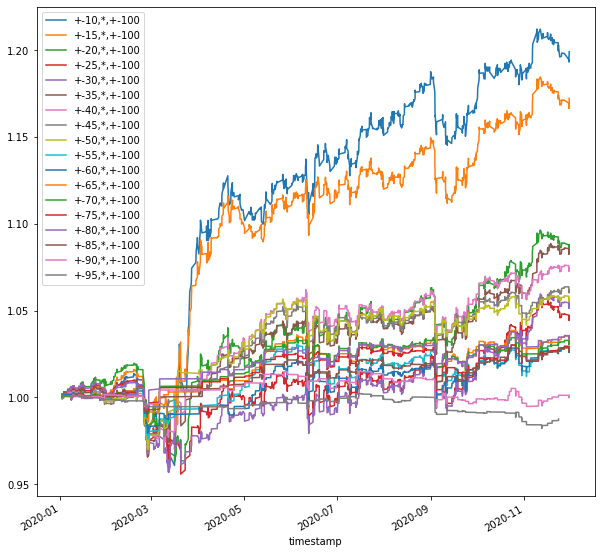

In [14]:
### Plot the +- 10 entry strategies compound returns
desc=[]
for entry in range(10,100,5):
  row_mask = (trades.entry.abs() == entry)
  desc.append(plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()), label='+-'+str(entry)+',*,+-100', figsize=(10,10)))

print(pd.concat(desc))

### **No stops 💎🤲 ** reproduces Isaacs repo no stops results, trade entries 9:30-15:55 and exits 9:35-16:00

In [15]:
combos = []
### list of [ENTRY, EXIT, STOP] combos to run
combos.extend([list(i) for i in it.product(*[np.arange(-95,-5,5),np.arange(-85,5,5),[-np.inf]]) if ((i[0] < i[1]) & (i[2] < i[0]))])
combos.extend([list(i) for i in it.product(*[np.arange(95,5,-5),np.arange(85,-5,-5),[np.inf]]) if ((i[0] > i[1]) & (i[2] > i[0]))])
combos = [combo for combo in combos if ~((np.abs(combo[0] - combo[1]) < 10))]

results, ensembles, trades = calcAllStrats(strat, combos, mask_func=mrMask)

100%|██████████| 342/342 [00:46<00:00,  7.34it/s]


In [16]:
print('Average trade percent profit',trades.pct_profit.mean())

Average trade percent profit 0.00032815176863229724


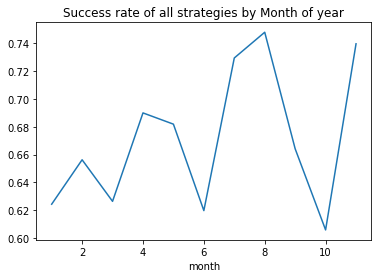

In [17]:
### No sign that success rates are falling

trades['month'] = trades.index.month
trades.groupby(['month'])['pct_profit'].apply(lambda x: (x > 0).sum() / x.count()).plot(title="Success rate of all strategies by Month of year")


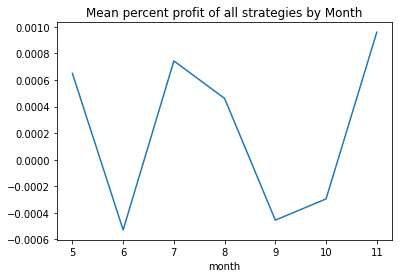

In [18]:
trades.groupby(['month'])['pct_profit'].apply(lambda x: x.mean()).iloc[4:].plot(title="Mean percent profit of all strategies by Month")

In [19]:
all_strats = trades.groupby('strat_name').first().loc[:,['entry',	'exit', 'stop',	'success_rate',	'total_trades', 'total_PNL',	'mean_of_returns',	'standard_deviation', 'average_hold_time',	'median_hold_time']]
longs = all_strats.loc[all_strats.entry < 0].sort_values(by=['entry','exit'], ascending=False)
shorts = all_strats.loc[all_strats.entry > 0].sort_values(by='entry', ascending=True)

In [20]:
#longresults5_noStop.csv reproduction
longs.groupby('entry').mean().sort_index(ascending=False)

,exit,stop,success_rate,total_trades,total_PNL,mean_of_returns,standard_deviation,average_hold_time,median_hold_time
entry,,,,,,,,,
-10.0,0.0,-inf,0.738839,448.000000,57.082600,0.127417,2.240145,101.015625,45.000000
-15.0,-2.5,-inf,0.731494,410.500000,61.395900,0.150842,2.303659,103.619958,50.000000
-20.0,-5.0,-inf,0.722275,370.333333,28.076900,0.077963,2.223988,106.628030,51.666667
-25.0,-7.5,-inf,0.696034,325.500000,11.477300,0.037436,2.306340,111.641388,57.500000
-30.0,-10.0,-inf,0.694796,298.800000,1.717420,0.003659,2.335175,111.730036,59.000000
-35.0,-12.5,-inf,0.702476,280.166667,20.512850,0.071060,2.375305,110.564901,59.583333
-40.0,-15.0,-inf,0.699352,246.285714,15.352871,0.054391,2.383230,112.428509,62.500000
-45.0,-17.5,-inf,0.684513,221.875000,17.583163,0.069228,2.422158,114.495314,66.875000
-50.0,-20.0,-inf,0.682384,194.333333,12.597522,0.056898,2.430454,117.381276,69.166667


In [21]:
shorts.groupby('entry').mean().sort_index(ascending=True)

,exit,stop,success_rate,total_trades,total_PNL,mean_of_returns,standard_deviation,average_hold_time,median_hold_time
entry,,,,,,,,,
10.0,0.0,inf,0.681818,396.000000,52.723700,0.133141,1.162673,85.909091,40.000000
15.0,2.5,inf,0.675883,348.000000,34.891850,0.100735,1.095223,89.344429,47.500000
20.0,5.0,inf,0.665138,305.666667,29.030333,0.095619,1.038808,91.506542,51.666667
25.0,7.5,inf,0.635152,260.500000,24.035500,0.091839,1.031031,94.945277,52.500000
30.0,10.0,inf,0.656739,246.000000,39.612600,0.163268,1.012147,91.729678,53.000000
35.0,12.5,inf,0.649273,213.833333,34.188000,0.162113,0.975397,93.687230,54.166667
40.0,15.0,inf,0.646313,186.000000,31.176571,0.172145,0.950229,94.569870,54.642857
45.0,17.5,inf,0.655365,163.250000,24.525625,0.155558,0.921894,96.954072,58.437500
50.0,20.0,inf,0.668973,147.888889,24.300556,0.170321,0.907778,96.646108,60.555556


              num_trades  mean_ret   ret_std  ret_skew  success_rate
+-10,*,+-inf       844.0  0.000474  0.006275  0.136792      0.710900
+-15,*,+-inf      1517.0  0.000462  0.006360 -0.437990      0.705339
+-20,*,+-inf      2028.0  0.000294  0.005997 -1.294340      0.696746
+-25,*,+-inf      2344.0  0.000208  0.006210 -1.202643      0.670222
+-30,*,+-inf      2724.0  0.000248  0.006218 -0.913042      0.678781
+-35,*,+-inf      2964.0  0.000387  0.006388 -0.442476      0.681174
+-40,*,+-inf      3026.0  0.000399  0.006402 -0.240669      0.677792
+-45,*,+-inf      3081.0  0.000392  0.006384 -0.605162      0.675755
+-50,*,+-inf      3080.0  0.000409  0.006433  0.218466      0.682792
+-55,*,+-inf      3030.0  0.000272  0.005972 -0.677200      0.683498
+-60,*,+-inf      2937.0  0.000303  0.005632 -1.546267      0.684372
+-65,*,+-inf      2896.0  0.000379  0.005641 -1.247099      0.686464
+-70,*,+-inf      2754.0  0.000423  0.005598 -1.248371      0.683370
+-75,*,+-inf      2686.0  0.000411

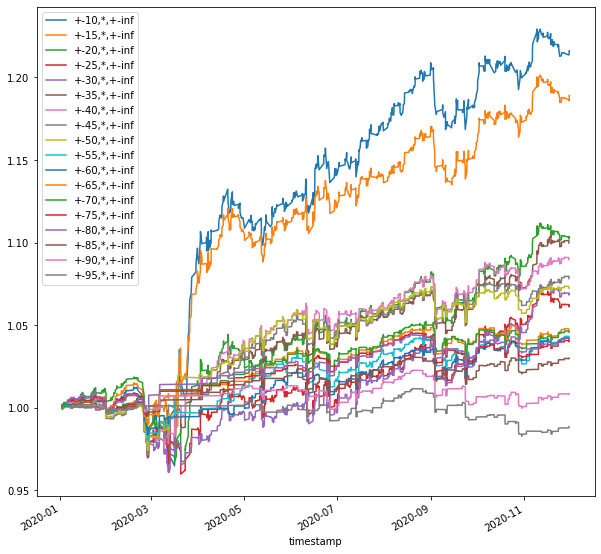

In [22]:
### Plot the compound returns
desc=[]
for entry in range(10,100,5):
  row_mask = (trades.entry.abs() == entry)
  desc.append(plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()), label='+-'+str(entry)+',*,+-inf', figsize=(10,10)))

print(pd.concat(desc))

,num_trades,mean_ret,ret_std,ret_skew,success_rate
all strats,45205.0,0.000328,0.005929,-0.764205,0.679372


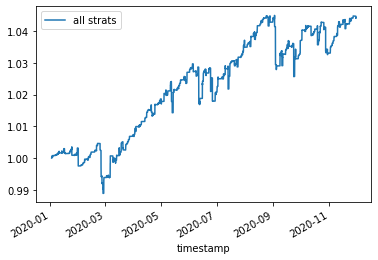

In [23]:
row_mask = (trades.entry.notnull())
plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()), label='all strats', figsize=(6,4))

            num_trades  mean_ret   ret_std  ret_skew  success_rate
+10,*,+inf       396.0  0.000452  0.003823 -0.040677      0.679293
+15,*,+inf       696.0  0.000312  0.003444 -0.647809      0.673851
+20,*,+inf       917.0  0.000287  0.003215 -0.810806      0.664122
+25,*,+inf      1042.0  0.000269  0.003138 -0.352769      0.635317
+30,*,+inf      1230.0  0.000490  0.003078 -0.193503      0.656098
+35,*,+inf      1283.0  0.000483  0.002907 -0.537680      0.648480
+40,*,+inf      1302.0  0.000519  0.002852 -0.573439      0.642857
+45,*,+inf      1306.0  0.000461  0.002747 -0.425976      0.653139
+50,*,+inf      1331.0  0.000509  0.002702 -0.450655      0.674681
+55,*,+inf      1277.0  0.000473  0.002751 -0.254957      0.667189
+60,*,+inf      1243.0  0.000600  0.002796 -0.152011      0.683829
+65,*,+inf      1205.0  0.000602  0.002522 -0.638631      0.717842
+70,*,+inf      1080.0  0.000552  0.002586 -0.539659      0.703704
+75,*,+inf      1019.0  0.000585  0.002665 -0.224637      0.69

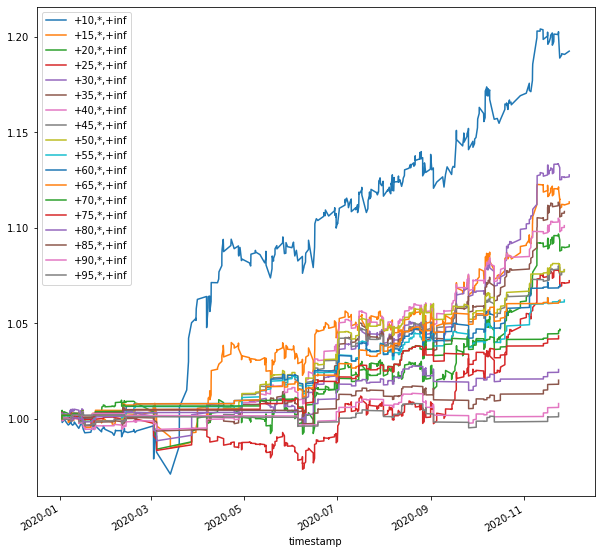

In [24]:
# the short legs
desc=[]
for entry in range(10,100,5):
  row_mask = (trades.entry.abs() == entry) & (trades.entry > trades.exit)
  desc.append(plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()), label='+'+str(entry)+',*,+inf', figsize=(10,10)))

print(pd.concat(desc))

            num_trades  mean_ret   ret_std  ret_skew  success_rate
-10,*,-inf       397.0  0.000615  0.007582  0.267726      0.743073
-15,*,-inf       722.0  0.000542  0.007689 -0.400511      0.731302
-20,*,-inf       991.0  0.000367  0.007286 -1.220125      0.728557
-25,*,-inf      1134.0  0.000196  0.007543 -0.900112      0.701058
-30,*,-inf      1283.0  0.000038  0.007702 -0.640895      0.681995
-35,*,-inf      1418.0  0.000299  0.007906 -0.253147      0.685472
-40,*,-inf      1478.0  0.000481  0.007809  0.258219      0.689445
-45,*,-inf      1524.0  0.000539  0.007511 -0.440227      0.703412
-50,*,-inf      1530.0  0.000512  0.007677 -0.151721      0.687582
-55,*,-inf      1471.0  0.000238  0.007256 -0.694797      0.671652
-60,*,-inf      1418.0  0.000030  0.006893 -1.808676      0.677715
-65,*,-inf      1424.0  0.000107  0.006922 -1.485280      0.681882
-70,*,-inf      1376.0  0.000061  0.006959 -1.443894      0.683866
-75,*,-inf      1321.0 -0.000064  0.007018 -1.438570      0.65

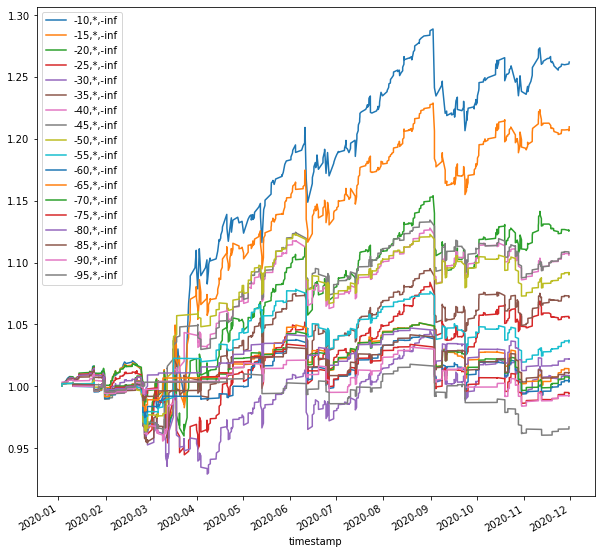

In [37]:
# the long legs
desc=[]
for entry in range(10,100,5):
  row_mask = (trades.entry.abs() == entry) & (trades.entry < trades.exit)
  desc.append(plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()), label='-'+str(entry)+',*,-inf', figsize=(10,10)))

print(pd.concat(desc))

,num_trades,mean_ret,ret_std,ret_skew,success_rate
"-95,*,-inf",185.0,0.000835,0.007767,-0.115487,0.724324


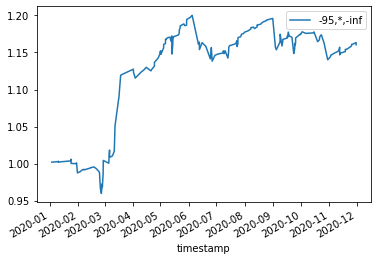

In [38]:
row_mask = (trades.entry == -50) &  (trades.exit == -30)
plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()), label='-'+str(50)+',*,-inf', figsize=(6,4))

### **waiting until 9:50, last entry at 3:30 and selling out at 3:45 reduces mean return significantly**

In [39]:
combos = []
### list of [ENTRY, EXIT, STOP] combos to run
combos.extend([list(i) for i in it.product(*[np.arange(-95,-5,5),np.arange(-85,5,5),[-np.inf]]) if ((i[0] < i[1]) & (i[2] < i[0]))])
combos.extend([list(i) for i in it.product(*[np.arange(95,5,-5),np.arange(85,-5,-5),[np.inf]]) if ((i[0] > i[1]) & (i[2] > i[0]))])
combos = [combo for combo in combos if ~((np.abs(combo[0] - combo[1]) < 10))]

results, ensembles, trades = calcAllStrats(strat, combos, mask_func=mrMask_ShortHours)

100%|██████████| 342/342 [00:49<00:00,  6.85it/s]


In [40]:
print('Average trade percent profit',trades.pct_profit.mean())

Average trade percent profit 0.00025895980541493647


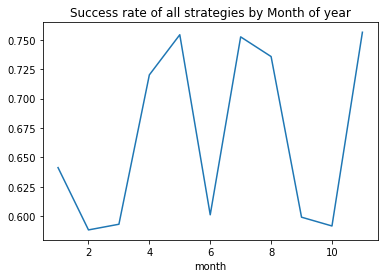

In [41]:
### No sign that success rates are falling

trades['month'] = trades.index.month
trades.groupby(['month'])['pct_profit'].apply(lambda x: (x > 0).sum() / x.count()).plot(title="Success rate of all strategies by Month of year")

In [42]:
all_strats = trades.groupby('strat_name').first().loc[:,['entry',	'exit', 'stop',	'success_rate',	'total_trades', 'total_PNL',	'mean_of_returns',	'standard_deviation', 'average_hold_time',	'median_hold_time']]
longs = all_strats.loc[all_strats.entry < 0].sort_values(by=['entry','exit'], ascending=False)
shorts = all_strats.loc[all_strats.entry > 0].sort_values(by='entry', ascending=True)

In [43]:
longs.groupby('entry').mean().sort_index(ascending=False)

,exit,stop,success_rate,total_trades,total_PNL,mean_of_returns,standard_deviation,average_hold_time,median_hold_time
entry,,,,,,,,,
-10.0,0.0,-inf,0.743073,397.000000,65.836100,0.165834,2.153003,100.780856,45.000000
-15.0,-2.5,-inf,0.730848,361.000000,52.885900,0.147152,2.199421,104.086257,55.000000
-20.0,-5.0,-inf,0.727242,330.333333,33.077400,0.101412,2.142222,105.860430,55.000000
-25.0,-7.5,-inf,0.700103,283.500000,14.888700,0.054405,2.223325,113.126830,64.375000
-30.0,-10.0,-inf,0.679794,256.600000,1.245940,0.002632,2.275693,114.609756,65.000000
-35.0,-12.5,-inf,0.680201,236.333333,16.629283,0.065915,2.347876,114.901069,69.166667
-40.0,-15.0,-inf,0.682802,211.142857,23.108100,0.100918,2.326318,114.763984,67.142857
-45.0,-17.5,-inf,0.695860,190.500000,24.934488,0.120947,2.308384,116.320549,72.500000
-50.0,-20.0,-inf,0.679985,170.000000,19.170300,0.103282,2.332859,117.358931,74.444444


In [44]:
shorts.groupby('entry').mean().sort_index(ascending=True)

,exit,stop,success_rate,total_trades,total_PNL,mean_of_returns,standard_deviation,average_hold_time,median_hold_time
entry,,,,,,,,,
10.0,0.0,inf,0.710914,339.000000,60.486400,0.178426,1.114236,88.407080,50.000000
15.0,2.5,inf,0.688442,301.000000,43.052750,0.143639,1.036632,90.680519,53.750000
20.0,5.0,inf,0.671753,266.333333,32.951333,0.123951,0.984701,91.870114,53.333333
25.0,7.5,inf,0.627744,218.250000,22.885250,0.103076,1.011632,98.299397,61.250000
30.0,10.0,inf,0.641722,204.800000,29.571400,0.145319,0.989682,95.322951,58.000000
35.0,12.5,inf,0.636830,179.166667,25.538167,0.143778,0.990947,96.627498,58.333333
40.0,15.0,inf,0.629948,147.571429,20.569000,0.143305,0.982775,102.348434,66.428571
45.0,17.5,inf,0.656781,128.500000,17.220000,0.139917,0.983055,105.054956,68.750000
50.0,20.0,inf,0.674556,116.888889,16.418667,0.147796,0.977901,104.569383,73.333333


              num_trades  mean_ret   ret_std  ret_skew  success_rate
+-10,*,+-inf       736.0  0.000607  0.006085  0.317626      0.728261
+-15,*,+-inf      1324.0  0.000501  0.006074 -0.459533      0.712236
+-20,*,+-inf      1790.0  0.000372  0.005778 -1.413021      0.704469
+-25,*,+-inf      2007.0  0.000244  0.006005 -1.076418      0.671649
+-30,*,+-inf      2307.0  0.000210  0.006067 -0.842940      0.666233
+-35,*,+-inf      2493.0  0.000356  0.006263 -0.352693      0.666667
+-40,*,+-inf      2511.0  0.000461  0.006275  0.262124      0.666268
+-45,*,+-inf      2552.0  0.000488  0.006091 -0.512775      0.685737
+-50,*,+-inf      2582.0  0.000481  0.006189 -0.195042      0.683579
+-55,*,+-inf      2468.0  0.000318  0.005911 -0.825872      0.670178
+-60,*,+-inf      2417.0  0.000249  0.005631 -2.056494      0.676872
+-65,*,+-inf      2335.0  0.000230  0.005680 -1.727123      0.675375
+-70,*,+-inf      2228.0  0.000193  0.005757 -1.666537      0.675943
+-75,*,+-inf      2109.0  0.000105

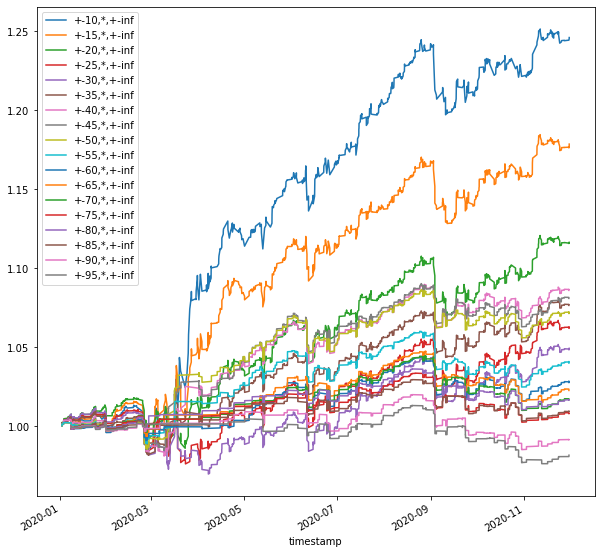

In [45]:
### Plot the compound returns
desc=[]
for entry in range(10,100,5):
  row_mask = (trades.entry.abs() == entry)
  desc.append(plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()), label='+-'+str(entry)+',*,+-inf', figsize=(10,10)))

print(pd.concat(desc))

,num_trades,mean_ret,ret_std,ret_skew,success_rate
all strats,37405.0,0.000259,0.005919,-0.940021,0.67376


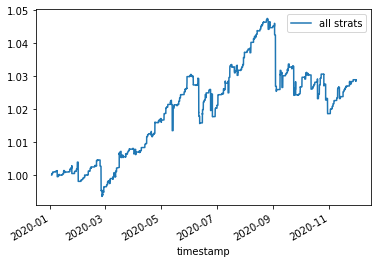

In [46]:
row_mask = (trades.entry.notnull())
plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()), label='all strats', figsize=(6,4))

            num_trades  mean_ret   ret_std  ret_skew  success_rate
+10,*,+inf       339.0  0.000597  0.003627  0.375956      0.710914
+15,*,+inf       602.0  0.000451  0.003209 -0.482220      0.689369
+20,*,+inf       799.0  0.000377  0.002999 -0.944172      0.674593
+25,*,+inf       873.0  0.000306  0.003005 -0.952977      0.633448
+30,*,+inf      1024.0  0.000426  0.002923 -0.989293      0.646484
+35,*,+inf      1075.0  0.000431  0.002920 -0.958323      0.641860
+40,*,+inf      1033.0  0.000431  0.002912 -0.935814      0.633107
+45,*,+inf      1028.0  0.000414  0.002911 -0.895532      0.659533
+50,*,+inf      1052.0  0.000437  0.002885 -0.853240      0.677757
+55,*,+inf       997.0  0.000435  0.002970 -0.594957      0.668004
+60,*,+inf       999.0  0.000559  0.003022 -0.457985      0.675676
+65,*,+inf       911.0  0.000422  0.002787 -0.866392      0.665203
+70,*,+inf       852.0  0.000407  0.002900 -0.846165      0.663146
+75,*,+inf       788.0  0.000388  0.002981 -0.662760      0.66

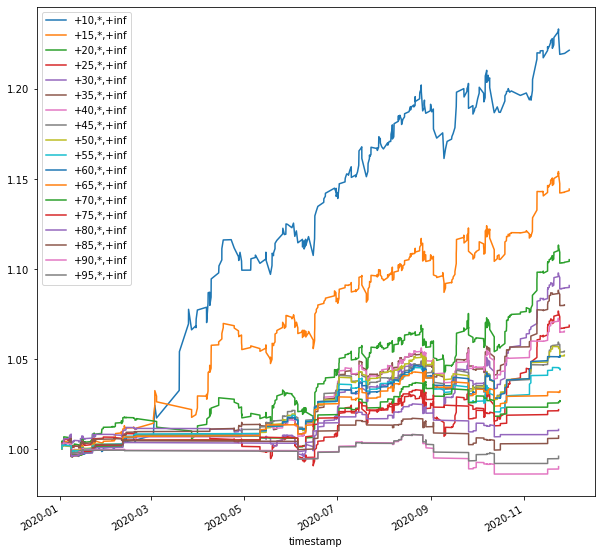

In [47]:
# the shorts
desc=[]
for entry in range(10,100,5):
  row_mask = (trades.entry.abs() == entry) & (trades.entry > trades.exit)
  desc.append(plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()), label='+'+str(entry)+',*,+inf', figsize=(10,10)))

print(pd.concat(desc))

            num_trades  mean_ret   ret_std  ret_skew  success_rate
-10,*,-inf       397.0  0.000615  0.007582  0.267726      0.743073
-15,*,-inf       722.0  0.000542  0.007689 -0.400511      0.731302
-20,*,-inf       991.0  0.000367  0.007286 -1.220125      0.728557
-25,*,-inf      1134.0  0.000196  0.007543 -0.900112      0.701058
-30,*,-inf      1283.0  0.000038  0.007702 -0.640895      0.681995
-35,*,-inf      1418.0  0.000299  0.007906 -0.253147      0.685472
-40,*,-inf      1478.0  0.000481  0.007809  0.258219      0.689445
-45,*,-inf      1524.0  0.000539  0.007511 -0.440227      0.703412
-50,*,-inf      1530.0  0.000512  0.007677 -0.151721      0.687582
-55,*,-inf      1471.0  0.000238  0.007256 -0.694797      0.671652
-60,*,-inf      1418.0  0.000030  0.006893 -1.808676      0.677715
-65,*,-inf      1424.0  0.000107  0.006922 -1.485280      0.681882
-70,*,-inf      1376.0  0.000061  0.006959 -1.443894      0.683866
-75,*,-inf      1321.0 -0.000064  0.007018 -1.438570      0.65

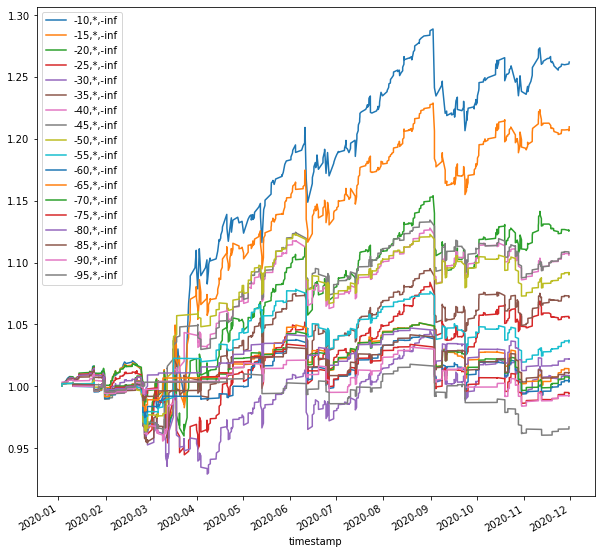

In [48]:
# the longs
desc=[]
for entry in range(10,100,5):
  row_mask = (trades.entry.abs() == entry) & (trades.entry < trades.exit)
  desc.append(plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()), label='-'+str(entry)+',*,-inf', figsize=(10,10)))

print(pd.concat(desc))